In [132]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [133]:

train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')


print(train_df.head().to_string(index=False))
print(test_df.head().to_string(index=False))


 Id         MW  NumOfAtoms  NumOfC  NumOfO  NumOfN  NumHBondDonors  NumOfConf  NumOfConfUsed       parentspecies  C.C..non.aromatic.  C.C.C.O.in.non.aromatic.ring  hydroxyl..alkyl.  aldehyde  ketone  carboxylic.acid  ester  ether..alicyclic.  nitrate  nitro  aromatic.hydroxyl  carbonylperoxynitrate  peroxide  hydroperoxide  carbonylperoxyacid  nitroester    pSat_Pa
  0  30.010565           4       1       1       0               0          1              1 apin_decane_toluene                   0                             0                 0         1       0                0      0                  0        0      0                  0                      0         0              0                   0           0 641974.491
  1  74.995643           6       1       3       1               0          1              1             toluene                   0                             0                 0         0       0                0      0                  0        0      1       

In [134]:
# Check correlation matrix train

train_no_parent_species = train_df.drop("parentspecies",axis=1)

rs = np.random.RandomState(0)
df = pd.DataFrame(rs.rand(10, 10))
corr = train_no_parent_species.corr()
corr.style.background_gradient(cmap='coolwarm')



,Id,MW,NumOfAtoms,NumOfC,NumOfO,NumOfN,NumHBondDonors,NumOfConf,NumOfConfUsed,C.C..non.aromatic.,C.C.C.O.in.non.aromatic.ring,hydroxyl..alkyl.,aldehyde,ketone,carboxylic.acid,ester,ether..alicyclic.,nitrate,nitro,aromatic.hydroxyl,carbonylperoxynitrate,peroxide,hydroperoxide,carbonylperoxyacid,nitroester,pSat_Pa
Id,1.000000,0.026424,0.425733,0.443363,-0.228807,0.059158,-0.194433,-0.025742,0.105289,-0.120198,0.013570,-0.076274,-0.193160,0.173053,-0.343453,-0.208477,-0.256153,0.213099,-0.180490,0.013822,-0.078021,-0.013827,0.144807,-0.110728,-0.101258,-0.005058
MW,0.026424,1.000000,0.709349,0.374515,0.882060,0.773514,0.079844,0.392975,0.294599,-0.157189,-0.079296,0.037394,-0.110615,-0.007093,-0.065872,-0.048986,-0.075448,0.478415,0.048196,-0.052306,0.467857,0.126222,0.062538,0.090920,0.022850,-0.039727
NumOfAtoms,0.425733,0.709349,1.000000,0.837380,0.325251,0.492933,-0.002743,0.453041,0.392108,-0.215539,-0.089732,-0.037236,-0.182362,0.045049,-0.163347,-0.207476,-0.228524,0.490813,-0.165924,-0.042769,0.180402,-0.132920,0.184887,-0.023661,-0.048387,-0.038407
NumOfC,0.443363,0.374515,0.837380,1.000000,-0.077281,0.127519,-0.168251,0.256517,0.285945,-0.063260,-0.006684,-0.126297,-0.074998,0.276709,-0.123855,-0.177116,-0.205700,0.262207,-0.207814,-0.008000,-0.021228,-0.223901,0.053357,-0.070361,-0.041009,-0.034076
NumOfO,-0.228807,0.882060,0.325251,-0.077281,1.000000,0.659971,0.246555,0.327225,0.146574,-0.119583,-0.071090,0.124272,-0.055297,-0.111853,0.019170,0.064478,0.025737,0.286366,0.126208,-0.054623,0.511823,0.279941,0.078740,0.172364,0.042936,-0.029639
NumOfN,0.059158,0.773514,0.492933,0.127519,0.659971,1.000000,-0.274195,0.094304,0.278153,-0.131669,-0.077282,-0.061534,-0.139149,-0.089246,-0.125529,-0.100557,-0.025304,0.688366,0.202889,-0.022926,0.386588,0.011083,-0.178728,-0.071655,0.047990,-0.013610
NumHBondDonors,-0.194433,0.079844,-0.002743,-0.168251,0.246555,-0.274195,1.000000,0.424820,-0.272930,-0.007382,0.002416,0.630046,-0.112551,-0.321653,0.269836,-0.009034,0.132682,-0.271633,0.100677,0.009192,-0.109210,0.089253,0.353101,0.172927,-0.025107,-0.020387
NumOfConf,-0.025742,0.392975,0.453041,0.256517,0.327225,0.094304,0.424820,1.000000,0.344840,-0.187095,-0.094788,0.125220,0.006129,-0.027500,0.181624,0.029002,-0.139953,0.129885,-0.108915,-0.026009,0.043459,-0.154075,0.379519,-0.077340,-0.008012,-0.010815
NumOfConfUsed,0.105289,0.294599,0.392108,0.285945,0.146574,0.278153,-0.272930,0.344840,1.000000,-0.123272,-0.098031,-0.361914,0.008616,0.084125,0.015140,0.035574,-0.161319,0.279462,-0.178530,-0.038191,0.166947,-0.142924,0.215257,-0.256394,0.005349,-0.016098
C.C..non.aromatic.,-0.120198,-0.157189,-0.215539,-0.063260,-0.119583,-0.131669,-0.007382,-0.187095,-0.123272,1.000000,0.322217,-0.097048,-0.042521,-0.196026,0.064830,0.097508,0.147162,-0.187532,0.080183,-0.007513,0.006869,-0.034179,0.028729,0.049010,0.015331,-0.002973


In [135]:
# Check correlation matrix train
test_no_parent_species = test_df.drop("parentspecies",axis=1)

rs = np.random.RandomState(0)
df = pd.DataFrame(rs.rand(10, 10))
corr = test_no_parent_species.corr()
corr.style.background_gradient(cmap='coolwarm')

,Id,MW,NumOfAtoms,NumOfC,NumOfO,NumOfN,NumHBondDonors,NumOfConf,NumOfConfUsed,C.C..non.aromatic.,C.C.C.O.in.non.aromatic.ring,hydroxyl..alkyl.,aldehyde,ketone,carboxylic.acid,ester,ether..alicyclic.,nitrate,nitro,aromatic.hydroxyl,carbonylperoxynitrate,peroxide,hydroperoxide,carbonylperoxyacid,nitroester
Id,1.000000,-0.021816,-0.021381,-0.016488,-0.013117,-0.022074,0.008585,0.010660,-0.000387,-0.025634,-0.023230,-0.004177,0.003977,0.030047,0.018582,-0.009687,-0.007762,-0.001912,-0.006809,-0.022329,-0.027461,0.004682,0.014348,-0.011848,-0.011282
MW,-0.021816,1.000000,0.675468,0.315728,0.888223,0.737467,0.113744,0.325620,0.201870,-0.163839,-0.082790,0.055917,-0.139313,-0.035471,-0.063410,-0.063319,-0.029899,0.463025,0.101677,-0.048350,0.426847,0.131431,0.037130,0.198748,0.009697
NumOfAtoms,-0.021381,0.675468,1.000000,0.831807,0.297137,0.420596,0.081234,0.441626,0.304524,-0.212203,-0.096341,0.013942,-0.209857,0.069112,-0.145373,-0.193292,-0.170535,0.429016,-0.100273,-0.041979,0.126840,-0.166377,0.174447,0.080977,-0.048163
NumOfC,-0.016488,0.315728,0.831807,1.000000,-0.121818,0.057743,-0.070028,0.277659,0.219371,-0.064986,-0.009852,-0.083199,-0.101473,0.321687,-0.089846,-0.157200,-0.156300,0.199989,-0.159793,-0.009675,-0.073692,-0.254606,0.066328,-0.004691,-0.031798
NumOfO,-0.013117,0.888223,0.297137,-0.121818,1.000000,0.622028,0.252269,0.254598,0.072520,-0.124941,-0.070756,0.140892,-0.078193,-0.169134,0.015257,0.028902,0.053444,0.286063,0.153725,-0.049066,0.460065,0.293946,0.063931,0.244496,0.023494
NumOfN,-0.022074,0.737467,0.420596,0.057743,0.622028,1.000000,-0.351975,-0.021725,0.235029,-0.127790,-0.077030,-0.147882,-0.130489,-0.063274,-0.165674,-0.085463,-0.024751,0.693427,0.221275,-0.015268,0.413842,0.002409,-0.263949,0.012100,0.033042
NumHBondDonors,0.008585,0.113744,0.081234,-0.070028,0.252269,-0.351975,1.000000,0.463438,-0.301809,0.000623,0.002464,0.699475,-0.115074,-0.279363,0.272642,-0.018791,0.129867,-0.306167,0.105163,0.005698,-0.201847,0.108233,0.401970,0.165579,-0.019249
NumOfConf,0.010660,0.325620,0.441626,0.277659,0.254598,-0.021725,0.463438,1.000000,0.252319,-0.141069,-0.089072,0.166471,0.006582,-0.030549,0.231538,0.018742,-0.059482,0.040536,-0.066879,-0.024914,-0.041225,-0.208318,0.391643,-0.038603,-0.008882
NumOfConfUsed,-0.000387,0.201870,0.304524,0.219371,0.072520,0.235029,-0.301809,0.252319,1.000000,-0.080876,-0.085068,-0.391615,0.008564,0.057844,0.012180,0.052832,-0.120727,0.235139,-0.190019,-0.033945,0.186314,-0.181507,0.159558,-0.224092,-0.009043
C.C..non.aromatic.,-0.025634,-0.163839,-0.212203,-0.064986,-0.124941,-0.127790,0.000623,-0.141069,-0.080876,1.000000,0.359961,-0.090359,-0.057304,-0.164614,0.080787,0.104497,0.178819,-0.173803,0.055020,-0.006650,0.006075,-0.083731,0.052885,0.013616,-0.003592


In [136]:

# missing values
missing_values_train = train_df.isnull().sum()
missing_values_test = test_df.isnull().sum()

print(missing_values_train.to_frame().T.to_string(index=False))
print(missing_values_test.to_frame().T.to_string(index=False))


 Id  MW  NumOfAtoms  NumOfC  NumOfO  NumOfN  NumHBondDonors  NumOfConf  NumOfConfUsed  parentspecies  C.C..non.aromatic.  C.C.C.O.in.non.aromatic.ring  hydroxyl..alkyl.  aldehyde  ketone  carboxylic.acid  ester  ether..alicyclic.  nitrate  nitro  aromatic.hydroxyl  carbonylperoxynitrate  peroxide  hydroperoxide  carbonylperoxyacid  nitroester  pSat_Pa
  0   0           0       0       0       0               0          0              0            206                   0                             0                 0         0       0                0      0                  0        0      0                  0                      0         0              0                   0           0        0
 Id  MW  NumOfAtoms  NumOfC  NumOfO  NumOfN  NumHBondDonors  NumOfConf  NumOfConfUsed  parentspecies  C.C..non.aromatic.  C.C.C.O.in.non.aromatic.ring  hydroxyl..alkyl.  aldehyde  ketone  carboxylic.acid  ester  ether..alicyclic.  nitrate  nitro  aromatic.hydroxyl  carbonylperoxynitrate  per

MV: missing values parentspecies, maybe something can be done?
MP: I suggest making a separate category for none and seeing where it's at, and then proceeding (probably just to ignore the values); the reason for the initial proposition is that there may be a systematic cause for null values

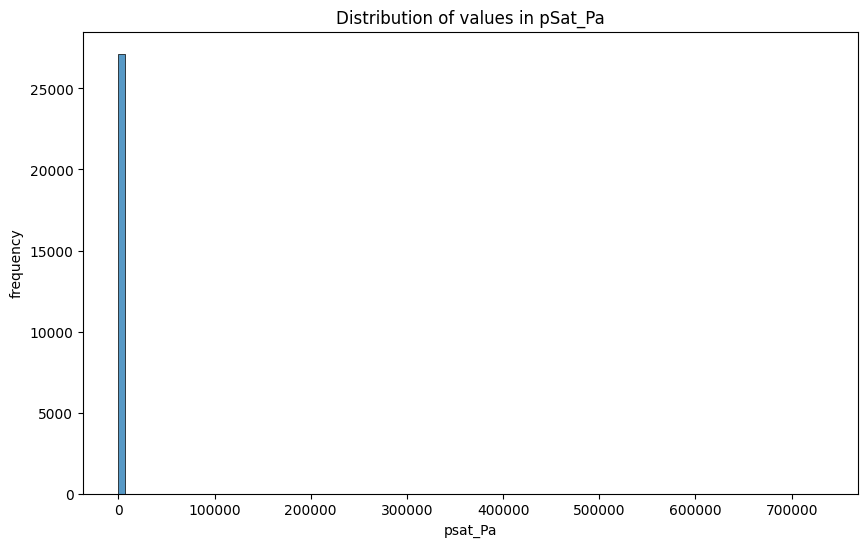

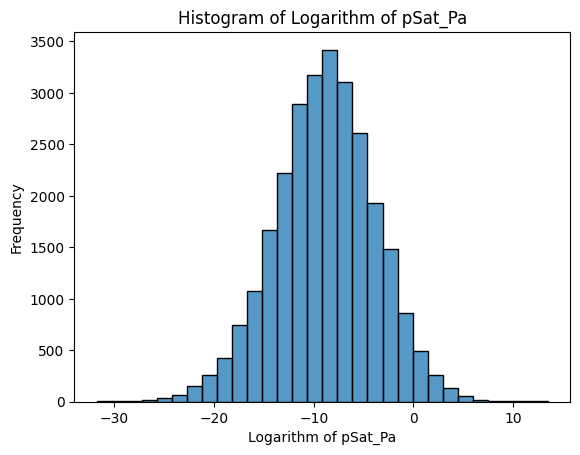

In [137]:

# distribution of pSat_Pa
plt.figure(figsize=(10, 6))
sns.histplot(train_df['pSat_Pa'], bins=100)
plt.title('Distribution of values in pSat_Pa')
plt.xlabel('psat_Pa')
plt.ylabel('frequency')
plt.show()

# Distribution of the logarithm of pSat_Pa
log = np.log(train_df['pSat_Pa'])
sns.histplot(log, bins=30)
plt.xlabel('Logarithm of pSat_Pa')
plt.ylabel('Frequency')
plt.title('Histogram of Logarithm of pSat_Pa')
plt.show()

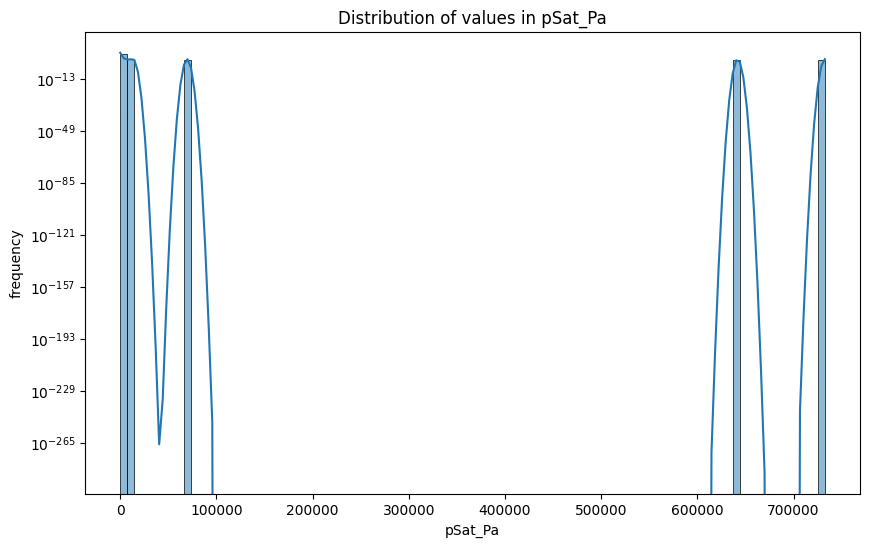

In [138]:

# with log scale y-axis with kde to estimate distribution
plt.figure(figsize=(10, 6))
sns.histplot(train_df['pSat_Pa'], bins=100, kde=True)
plt.title('Distribution of values in pSat_Pa')

plt.ylabel('frequency')
plt.yscale('log')
plt.show()


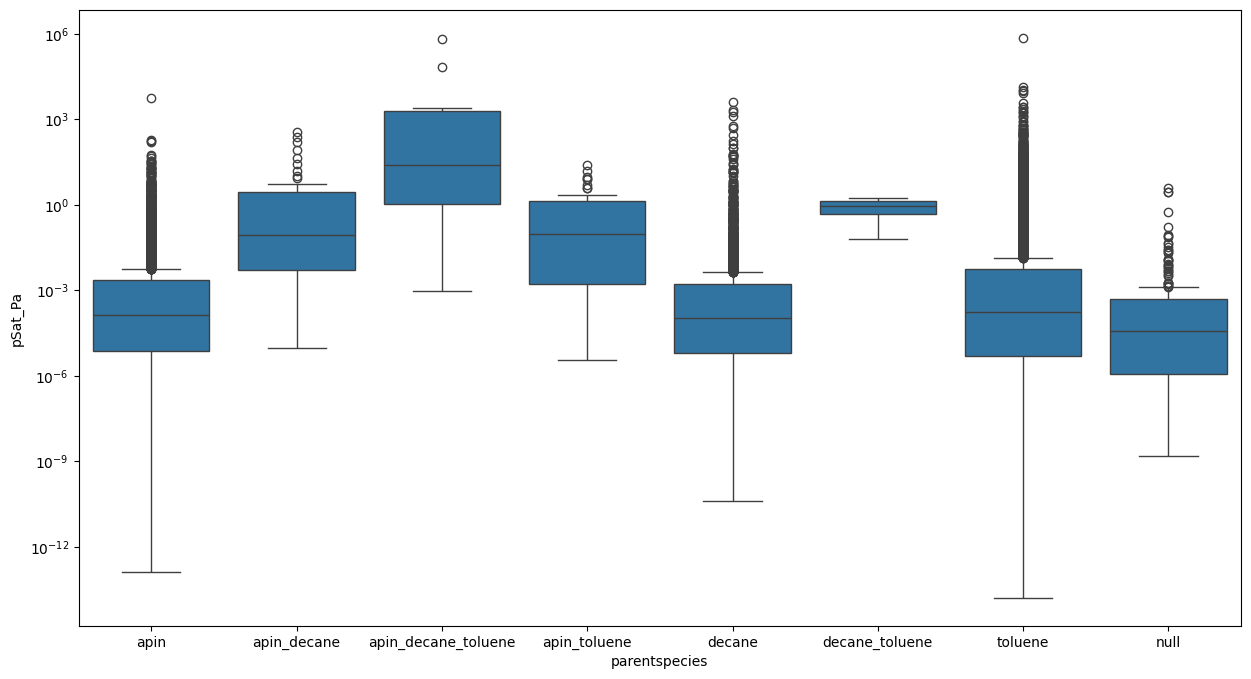

In [139]:
# Check parent species affect on pSat_Pa
null_vals_as_cat = train_df
null_vals_as_cat['parentspecies'] = null_vals_as_cat['parentspecies'].fillna("null").astype("category")
custom_order = [cat for cat in null_vals_as_cat['parentspecies'].cat.categories if cat != 'null'] + ['null']
null_vals_as_cat['parentspecies'] = null_vals_as_cat['parentspecies'].cat.set_categories(custom_order)

plt.figure(figsize=(15, 8))
sns.boxplot(data=null_vals_as_cat, x='parentspecies', y='pSat_Pa')
plt.yscale('log')
plt.show()

In [140]:


# processing the data ----------------------------------------------
# log transform + adding  constant to avoid log(0)
train_df['pSat_Pa_log'] = np.log(train_df['pSat_Pa'] + 1e-10)

# parentspecies is a categorical variable -> one-hot encoding
# scaling the numerical variables
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), train_df.select_dtypes(include=['float64', 'int64']).columns.drop(['Id', 'pSat_Pa', 'pSat_Pa_log'])),
        ('cat', OneHotEncoder(), ['parentspecies'])
    ])

# Splitting the data into training and validation sets
X = train_df.drop(columns=['Id', 'pSat_Pa', 'pSat_Pa_log'])
y = train_df['pSat_Pa_log']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1)

preprocessing_pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# Fit and transform the training data
X_train_preprocessed = preprocessing_pipeline.fit_transform(X_train)

# Transform the validation data
X_val_preprocessed = preprocessing_pipeline.transform(X_val)

X_train_preprocessed.shape, X_val_preprocessed.shape


((21717, 32), (5430, 32))

In [175]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, Lasso


rf_model = RandomForestRegressor(random_state=1)
gb_model = GradientBoostingRegressor(random_state=1)
knn_model = KNeighborsRegressor(n_neighbors=12)
mlr_model = LinearRegression()


# Random forest
rf_model.fit(X_train_preprocessed, y_train)
y_pred_rf = rf_model.predict(X_val_preprocessed)
r2_rf = r2_score(y_val, y_pred_rf)

# Gradient boosting
gb_model.fit(X_train_preprocessed, y_train)
y_pred_gb = gb_model.predict(X_val_preprocessed)
r2_gb = r2_score(y_val, y_pred_gb)

# multiple linear regresion
mlr_model.fit(X_train_preprocessed, y_train)
y_pred_gb = mlr_model.predict(X_val_preprocessed)
r2_mlr = r2_score(y_val, y_pred_gb)

# lasso regression
lasso_model = Lasso(alpha=0.1)
lasso_model.fit(X_train_preprocessed, y_train)
y_pred_lasso = lasso_model.predict(X_val_preprocessed)
r2_lasso = r2_score(y_val, y_pred_lasso)

r2_rf, r2_gb, r2_mlr, r2_lasso


(0.7202271731628987,
 0.732411451956821,
 0.6889563777928204,
 0.7117339269753261,
 0.7006663113680229)